# EDSA 2021: Sendy Logistics Challenge

# INTRODUCTION

Sendy is an online business platform set up to enable businesses and private individuals to transport goods more efficiently. The company is headquarted in Kenya. 

The objective of this challenge, hosted on the Zindi platform, is to predict the amount of time it will take a motorbike to deliver a parcel to its destination. The target feature is 'Time from Pickup to Arrival'.

This is a regression problem where participants are required to make use of linear models with a view to minimising the loss as measured by the 'root mean squared error' (RMSE). Competition entrants are restricted to students at the Explore Data Science Academy based in South Africa.

# BODY

## 1. Package Installation

In [1]:
!pip install category_encoders
!pip install geopy

## 2. Importing Libraries

Not all librarires that were imported are shown below. Some further libraries are reflected later in the notebook, being imported as and when the need arose. Powerful functions have been imported from the preprocessing library, the metrics library and linear models library. Pandas has been used extensively throughout the notebook in analysing and manipulating the data. 

In [2]:
import pandas as pd
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

## 3. Importing Data

Train and test sets, containing thousands of datapoints pertaining to parcel deliveries by motorbikes, were downloaded from the Zindi platform. In addition a riders set, containing information about the bike riders was also downloaded and subseuently merged separately with the train and test sets. The submission file is in csv format and needs to be populated with the first column containing the Order Id's (of test set data) and the second column containing corresponding predictions for delivery times.    

In [3]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
Submission = pd.read_csv("SampleSubmission.csv")
riders = pd.read_csv("Riders.csv")

## 4. Data Cleaning & Formatting

In [4]:
# Get a feel for the data and inspect missing entries
train.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


Missing entries (NaN) can be found under the following columns: 'Temperature' and 'Precipitation in millimeters'.   

In [5]:
# Get an indication of how many null values there are
print(train.isnull().sum())
train.isnull().sum() / len(train)

Order No                                         0
User Id                                          0
Vehicle Type                                     0
Platform Type                                    0
Personal or Business                             0
Placement - Day of Month                         0
Placement - Weekday (Mo = 1)                     0
Placement - Time                                 0
Confirmation - Day of Month                      0
Confirmation - Weekday (Mo = 1)                  0
Confirmation - Time                              0
Arrival at Pickup - Day of Month                 0
Arrival at Pickup - Weekday (Mo = 1)             0
Arrival at Pickup - Time                         0
Pickup - Day of Month                            0
Pickup - Weekday (Mo = 1)                        0
Pickup - Time                                    0
Arrival at Destination - Day of Month            0
Arrival at Destination - Weekday (Mo = 1)        0
Arrival at Destination - Time  

Order No                                     0.000000
User Id                                      0.000000
Vehicle Type                                 0.000000
Platform Type                                0.000000
Personal or Business                         0.000000
Placement - Day of Month                     0.000000
Placement - Weekday (Mo = 1)                 0.000000
Placement - Time                             0.000000
Confirmation - Day of Month                  0.000000
Confirmation - Weekday (Mo = 1)              0.000000
Confirmation - Time                          0.000000
Arrival at Pickup - Day of Month             0.000000
Arrival at Pickup - Weekday (Mo = 1)         0.000000
Arrival at Pickup - Time                     0.000000
Pickup - Day of Month                        0.000000
Pickup - Weekday (Mo = 1)                    0.000000
Pickup - Time                                0.000000
Arrival at Destination - Day of Month        0.000000
Arrival at Destination - Wee

Approximately 97% of the values for 'Precipitation in millimetres' are missing. This is strange since a quick investigation of Nairobi's climate (where most of these bike deliveries take place) informs us that the city experiences rain for as much as two-thirds of the year. It seems as though precipitation values have not been recorded for most of the data points and, consequently, this variable becomes a good candidate for dropping from the dataset.

'Temperature', on the other hand, is only missing 20% of its values. We can, therefore, consider imputing mean, median or mode values for these missing entries.  

In [6]:
# Determine the number of datapoints in the train dataset
len(train)

21201

In [7]:
# Ascertain what variables (columns) are present as well as their corresponding data types 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [8]:
# Get a feel for statistical summary measures and asertain data ranges (max - min)
train.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


Conduct a similar analysis of the test set.

In [9]:
test.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

In [11]:
test.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,5631.000000,199.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.246120,6.651759,-1.282043,36.811148,-1.282255,36.811326
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.591161,14.085439,0.030044,0.037962,0.034236,0.043507
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,0.100000,-1.433512,36.653828,-1.422652,36.639195
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.100000,-1.301201,36.784605,-1.300921,36.786546
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,2.900000,-1.281301,36.807219,-1.283219,36.807927
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.900000,4.950000,-1.257274,36.829716,-1.261256,36.828195
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,99.100000,-1.148352,36.991046,-1.030225,37.018958


## 5. Exploratory Data Analysis

In the early stages of the project an exploratory data analysis (EDA) was perfomed, analyzing the data sets (train, test and riders) and summarizing their main characteristics. Statistical graphics and other data visualization methods have been employed to better understand the data and discern patterns as well as correlations between variables.

This section highlights some of the most important variables, each being supported with one or more visualisations and a brief statement highlighting the message conveyed ('finding') by the chart. 

<b> Temperature </b>

Investigate the distribution of Temperature values for the Train dataset.

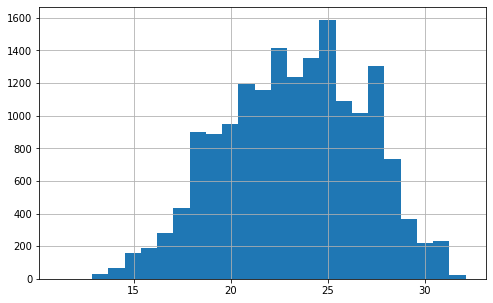

In [12]:
hist_temp = train.Temperature.hist(bins=25,figsize=[8,5])

The mode (most common value) is 25 degrees Celcius. Temperatures do not get very low which means that bike deliveries would not be negatively affected by snow or ice (hardly surprising in such an equatorial setting). 

<b> Platform </b>

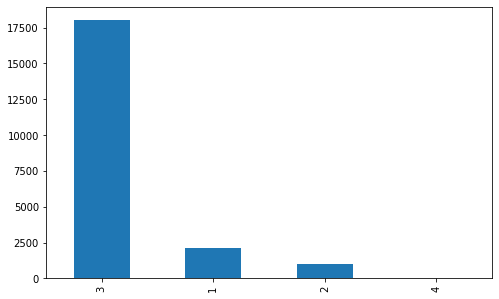

In [13]:
train['Platform Type'].value_counts().plot(kind='bar',figsize=[8,5])

We have not been told what the above dummy values (1, 2, 3, 4) represent. What we can conclude from the above, however, is that the vast majority of orders are made using platform 3. Whether platform type makes any difference in delivery time remains to be seen when building our models.

<b> Personal or Business </b>

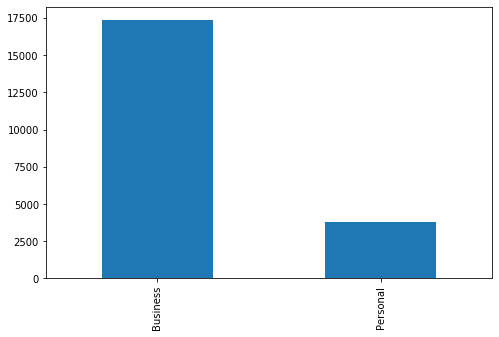

In [14]:
train['Personal or Business'].value_counts().plot(kind='bar',figsize=[8,5])

Business transactions clearly dominate. We can try use this as a variable in our model to see whether it has any correlation with delivery times. 

<b> Arrival at Pickup - Day of Month </b> 

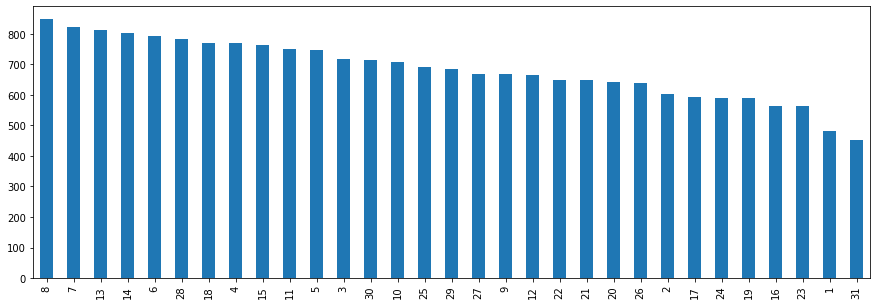

In [15]:
train['Arrival at Pickup - Day of Month'].value_counts().plot(kind='bar',figsize=[15,5])

It's difficult to ascertain much from the above chart. Naturally, the 31st would consist of the fewest values since only 7 of the of the months in the year have 31 days in them. We don't know over what period of time (or which specific months) the data was collected for.  

<b> Arrival at Pickup - Weekday </b>

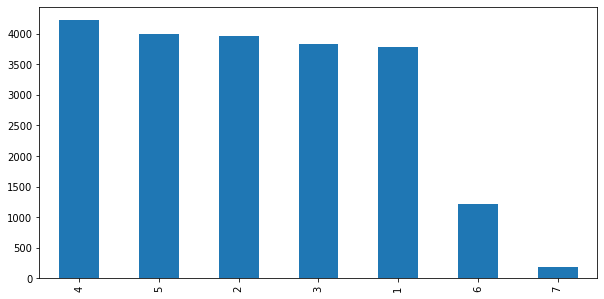

In [16]:
train['Arrival at Pickup - Weekday (Mo = 1)'].value_counts().plot(kind='bar',figsize=[10,5])

Understandably, there are considerably fewer deliveries on weekends (Days 6 and 7) with minimal figures on Sundays. One would expect less traffic on weekends (particularly Sundays) and, therefore, speedier deliveries.

<b> Pickup Hour </b>

In [17]:
# Convert Pickup times to datetime
train['Pickup - Time'] = pd.to_datetime(train['Pickup - Time'])
train['Arrival at Destination - Time'] = pd.to_datetime(train['Arrival at Destination - Time'])

In [18]:
# Extract the hour, minute and second
train['Pickup_Hour'] = train['Pickup - Time'].dt.hour
train['Pickup_Minutes'] = train['Pickup - Time'].dt.minute
train['Pickup_Seconds'] = train['Pickup - Time'].dt.second
train['Arrival_Destination_Hour'] = train['Arrival at Destination - Time'].dt.hour
train['Arrival_Destination_Minutes'] = train['Arrival at Destination - Time'].dt.minute
train['Arrival_Destination_Seconds'] = train['Arrival at Destination - Time'].dt.second

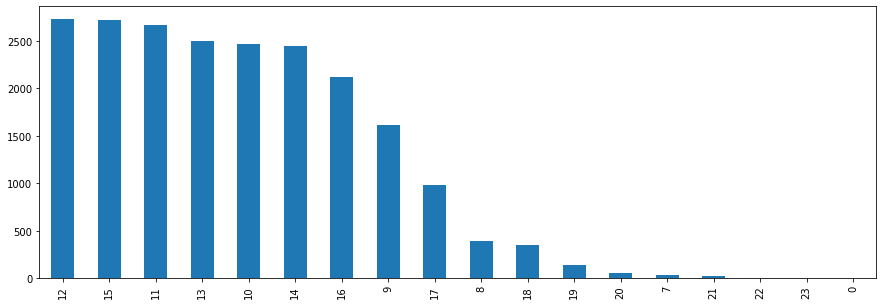

In [19]:
train['Pickup_Hour'].value_counts().plot(kind='bar',figsize=[15,5])

Most pickup times occur during normal business hours (9AM to 5PM)

<b> Hour of Dropoff (Destination) </b>

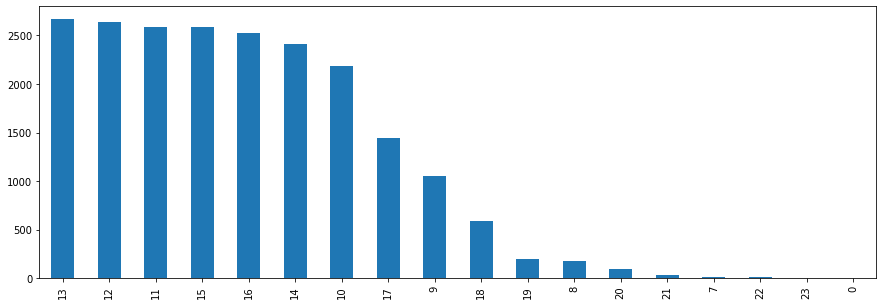

In [20]:
train['Arrival_Destination_Hour'].value_counts().plot(kind='bar',figsize=[15,5])

This shows a remarkable similarity with the distribution of hours for pickup.  

<b> Distance </b>

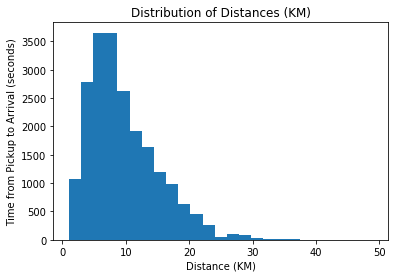

In [21]:
#hist_temp = train['Distance (KM)'].hist(bins=25,figsize=[8,5])
plt.hist(train['Distance (KM)'], bins=25)
plt.title('Distribution of Distances (KM)')
plt.xlabel('Distance (KM)')
plt.ylabel('Time from Pickup to Arrival (seconds)')
plt.show()

The distribution is skewed towards the right meaning that a log transform will be required to normalise the data. Most rides are less than 10km.

<b>Speed</b>

Speed would naturally be a vitally important variable in predicing travel time. We can create a speed feature (feature engineering). Since our target variable ('Time from Pickup to Arrival') is measured in seconds, it makes sense to convert distance from kilometers to metres for easier interpretation.

In [22]:
train['Speed_Meter_per_Second'] = (train['Distance (KM)']*1000)/train['Time from Pickup to Arrival']

In [23]:
train.Speed_Meter_per_Second.describe()

count    21201.000000
mean        69.251494
std        529.249252
min          0.255624
25%          4.573171
50%          6.406834
75%          8.413462
max      17000.000000
Name: Speed_Meter_per_Second, dtype: float64

Observing the range (min and max) shows that there are some extreme outliers in the dataset. A minimum average speed of 0.255624 metres per second (m/s) translates into 0.92km/hr. The maximum average speed of 17000 m/s translates to 61,200km/hr (considerably faster than the speed of a rocket in orbit which is approximately 28,000 km/hr). It seems as though some riders are recording their pickup times upon arrival at their destination and momentarily afterwards recording the delivery. If we are going to make meaningful predictions, we need to get rid of such outliers.

<b> Visualising Speed Distribution in absence of outliers </b>

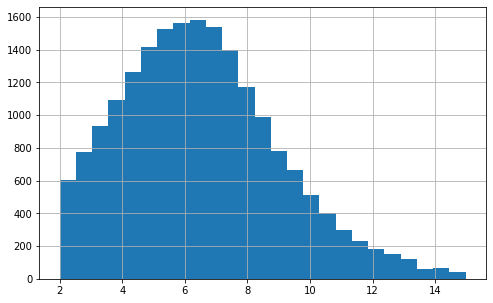

In [24]:
OutliersTrain = train[(train.Speed_Meter_per_Second>=15)|(train.Speed_Meter_per_Second<=2)]#.sort_values(by='Speed_Meter_per_',ascending=False)
OutlierFreeTrain = train[~(train['Order No'].isin(OutliersTrain['Order No']))]
hist_Speedmin = OutlierFreeTrain['Speed_Meter_per_Second'].hist(bins=25,figsize=[8,5])

In [25]:
print('In terms of the min and max speeds set, there are %i outliers in our dataset. It\'s quite possible, though, that we have classified a few normal rides as outliers.'%(len(OutliersTrain)))

In terms of the min and max speeds set, there are 1856 outliers in our dataset. It's quite possible, though, that we have classified a few normal rides as outliers.


In [26]:
OutlierFreeTrain.Speed_Meter_per_Second.describe()

count    19345.000000
mean         6.517542
std          2.506272
min          2.000667
25%          4.662005
50%          6.324111
75%          8.064516
max         14.970060
Name: Speed_Meter_per_Second, dtype: float64

The median (50th percentile) speed is 6.32m per second which translates to 22.75km/hr (multiply by 3.6 to convert). This may not sound very fast but we need to recall that the majority of deliveries are probably within urban environments where there is traffic congestion, traffic lights and stop streets to contend with.

<b> Riders </b>

Let's determine if there are certain riders responsible for the outliers at the high end (faster than 15m/s). 

In [27]:
plot1=train[train['Speed_Meter_per_Second']>=15]
#plot1.groupby('Rider Id').agg('count').sort_values(by='Order No',ascending=False)
riders['WrongOrders'] = riders['Rider Id'].map(plot1.groupby('Rider Id').agg('count').sort_values(by='Order No',ascending=False)['Order No'])
#riders['error_rate'] = riders['WrongOrders']/riders['No_Of_Orders']

In [28]:
train['Total_Orders'] = train['Rider Id'].map(train.groupby('Rider Id').agg('count')['Order No'])
train = pd.merge(train,riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
test = pd.merge(test,riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
train['error_rate_rider'] = train['WrongOrders']/train['Total_Orders']
test['error_rate_rider'] = test['Rider Id'].map(train['error_rate_rider'])

In [29]:
len(train[train.error_rate_rider>=0.5])

506

Of the 21201 entries in the train dataset, 506 of these pertain to riders who travel at an abnormally high speed (in terms of our admittedly subjective interpretation of 15m/s being excessively fast).

Let's ascertain whether the train and test sets share the same riders.

In [30]:
print('There are %i unique riders in train set and %i in test set'%(len(train['Rider Id'].unique()),len(test['Rider Id'].unique())))

There are 924 unique riders in train set and 822 in test set


How many riders are exclusive to each of these two sets?

In [31]:
riderstrainonly = len(train[~(train['Rider Id'].isin(test['Rider Id'].unique()))]['Rider Id'].unique())
riderstestonly = len(test[~(test['Rider Id'].isin(train['Rider Id'].unique()))]['Rider Id'].unique())
print('%i riders are exclusive to the train set whilst %i riders exist only in the test set' %(riderstrainonly,riderstestonly))

130 riders are exclusive to the train set whilst 28 riders exist only in the test set


<b> Riders who are perpetually slow </b>

In [32]:
## convert target from seconds to minutes.
train['Time_from_Pickup_to_Arrival_Minutes'] = train['Time from Pickup to Arrival']/60

In [33]:
idxlate=train[train.Speed_Meter_per_Second<=2][['Distance (KM)','Speed_Meter_per_Second','Time from Pickup to Arrival','Time_from_Pickup_to_Arrival_Minutes']].index
train.iloc[idxlate]['Rider Id'].value_counts().head(5)

Rider_Id_268    14
Rider_Id_88     10
Rider_Id_155     8
Rider_Id_519     8
Rider_Id_362     8
Name: Rider Id, dtype: int64

In [34]:
print('We can surmise that %i orders took too long to reach their destination. '%(len(train[train.Speed_Meter_per_Second<2])))

We can surmise that 684 orders took too long to reach their destination. 


<b> Distribution of Pickup Times (by hour) </b>

In [35]:
train.Pickup_Hour.value_counts()

12    2725
15    2720
11    2669
13    2493
10    2459
14    2443
16    2121
9     1606
17     984
8      385
18     343
19     138
20      53
7       34
21      22
22       4
23       1
0        1
Name: Pickup_Hour, dtype: int64

In [36]:
train.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
train.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<=11),'DayTime']= 'Matin'
train.loc[(train['Pickup_Hour']>11)&(train['Pickup_Hour']<=13),'DayTime']= '9ayla'
train.loc[(train['Pickup_Hour']>13)&(train['Pickup_Hour']<17),'DayTime']= 'ApresMidi'
train.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'
train.loc[(train['Pickup_Hour']>19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'

In [37]:
print(len(train[train['DayTime']=='Rush_Hour2']))
len(train[train['DayTime']=='Rush_Hour2']) / len(train)

1465


0.06910051412669213

In [38]:
print(len(train[train['DayTime']=='Rush_Hour1']))
len(train[train['DayTime']=='Rush_Hour1']) / len(train)

419


0.019763218716098298

There were considerably more parcel deliveries during the 2nd daily rush hour (weekdays), i.e. between 5pm and 7pm.

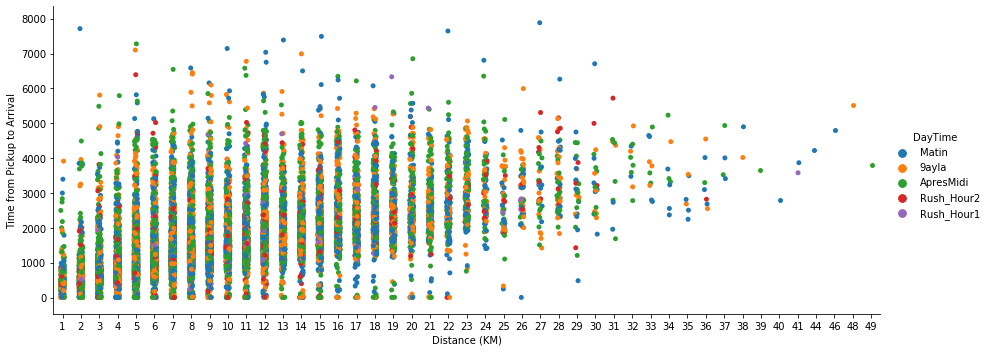

In [39]:
g = sns.catplot(x="Distance (KM)", y="Time from Pickup to Arrival",hue="DayTime",
                   data=train, aspect=2.5, height=5, ci=80.0)

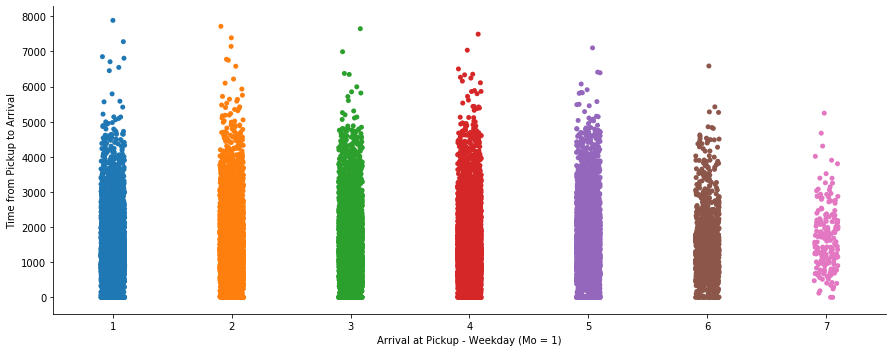

In [40]:
g = sns.catplot(x="Arrival at Pickup - Weekday (Mo = 1)", y="Time from Pickup to Arrival",#hue="",
                   data=train, aspect=2.5, height=5, ci=80.0)

Parcel delivery times were fairly similar between Monday and Friday with understandably quicker deliveries on the weekend.

In [41]:
# Let's count the number of deliveries that took longer than 5000 sec (approx 83 minutes) 
train[train['Time from Pickup to Arrival']>=5000]['Distance (KM)'].value_counts().sort_values()

2     1
30    1
26    1
25    1
23    1
34    1
48    1
4     1
31    1
21    2
3     2
27    2
28    3
6     3
24    3
7     3
14    3
17    3
19    4
22    4
13    4
8     5
16    5
11    6
10    6
15    7
5     7
12    7
18    7
20    8
9     8
Name: Distance (KM), dtype: int64

Long delivery times were not only recorded when high distances were travelled. There were 7 occasions when it took more than 5000 seconds to deliver parcels to destinations that were only 5km away. These lengthy delivery times are visualised in the chart below.

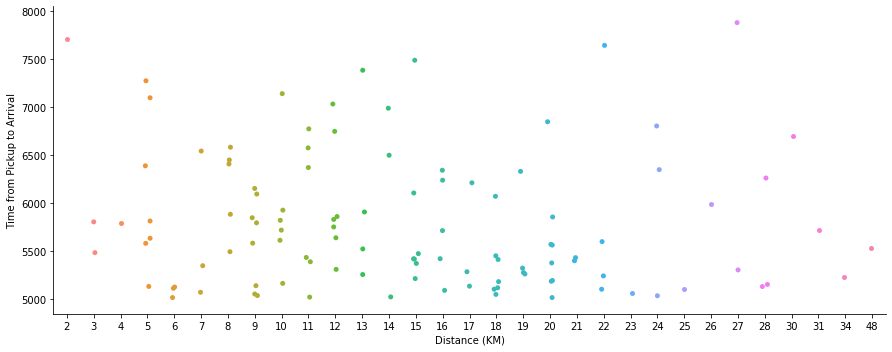

In [42]:
#longtime=train[train['Time from Pickup to Arrival']>=5000].copy()
g = sns.catplot(x="Distance (KM)", y="Time from Pickup to Arrival",#col="cluster_destination",
                   data=train[train['Time from Pickup to Arrival']>=5000], aspect=2.5, height=5, ci=80.0)

<b> Observing correlation between variables </b>

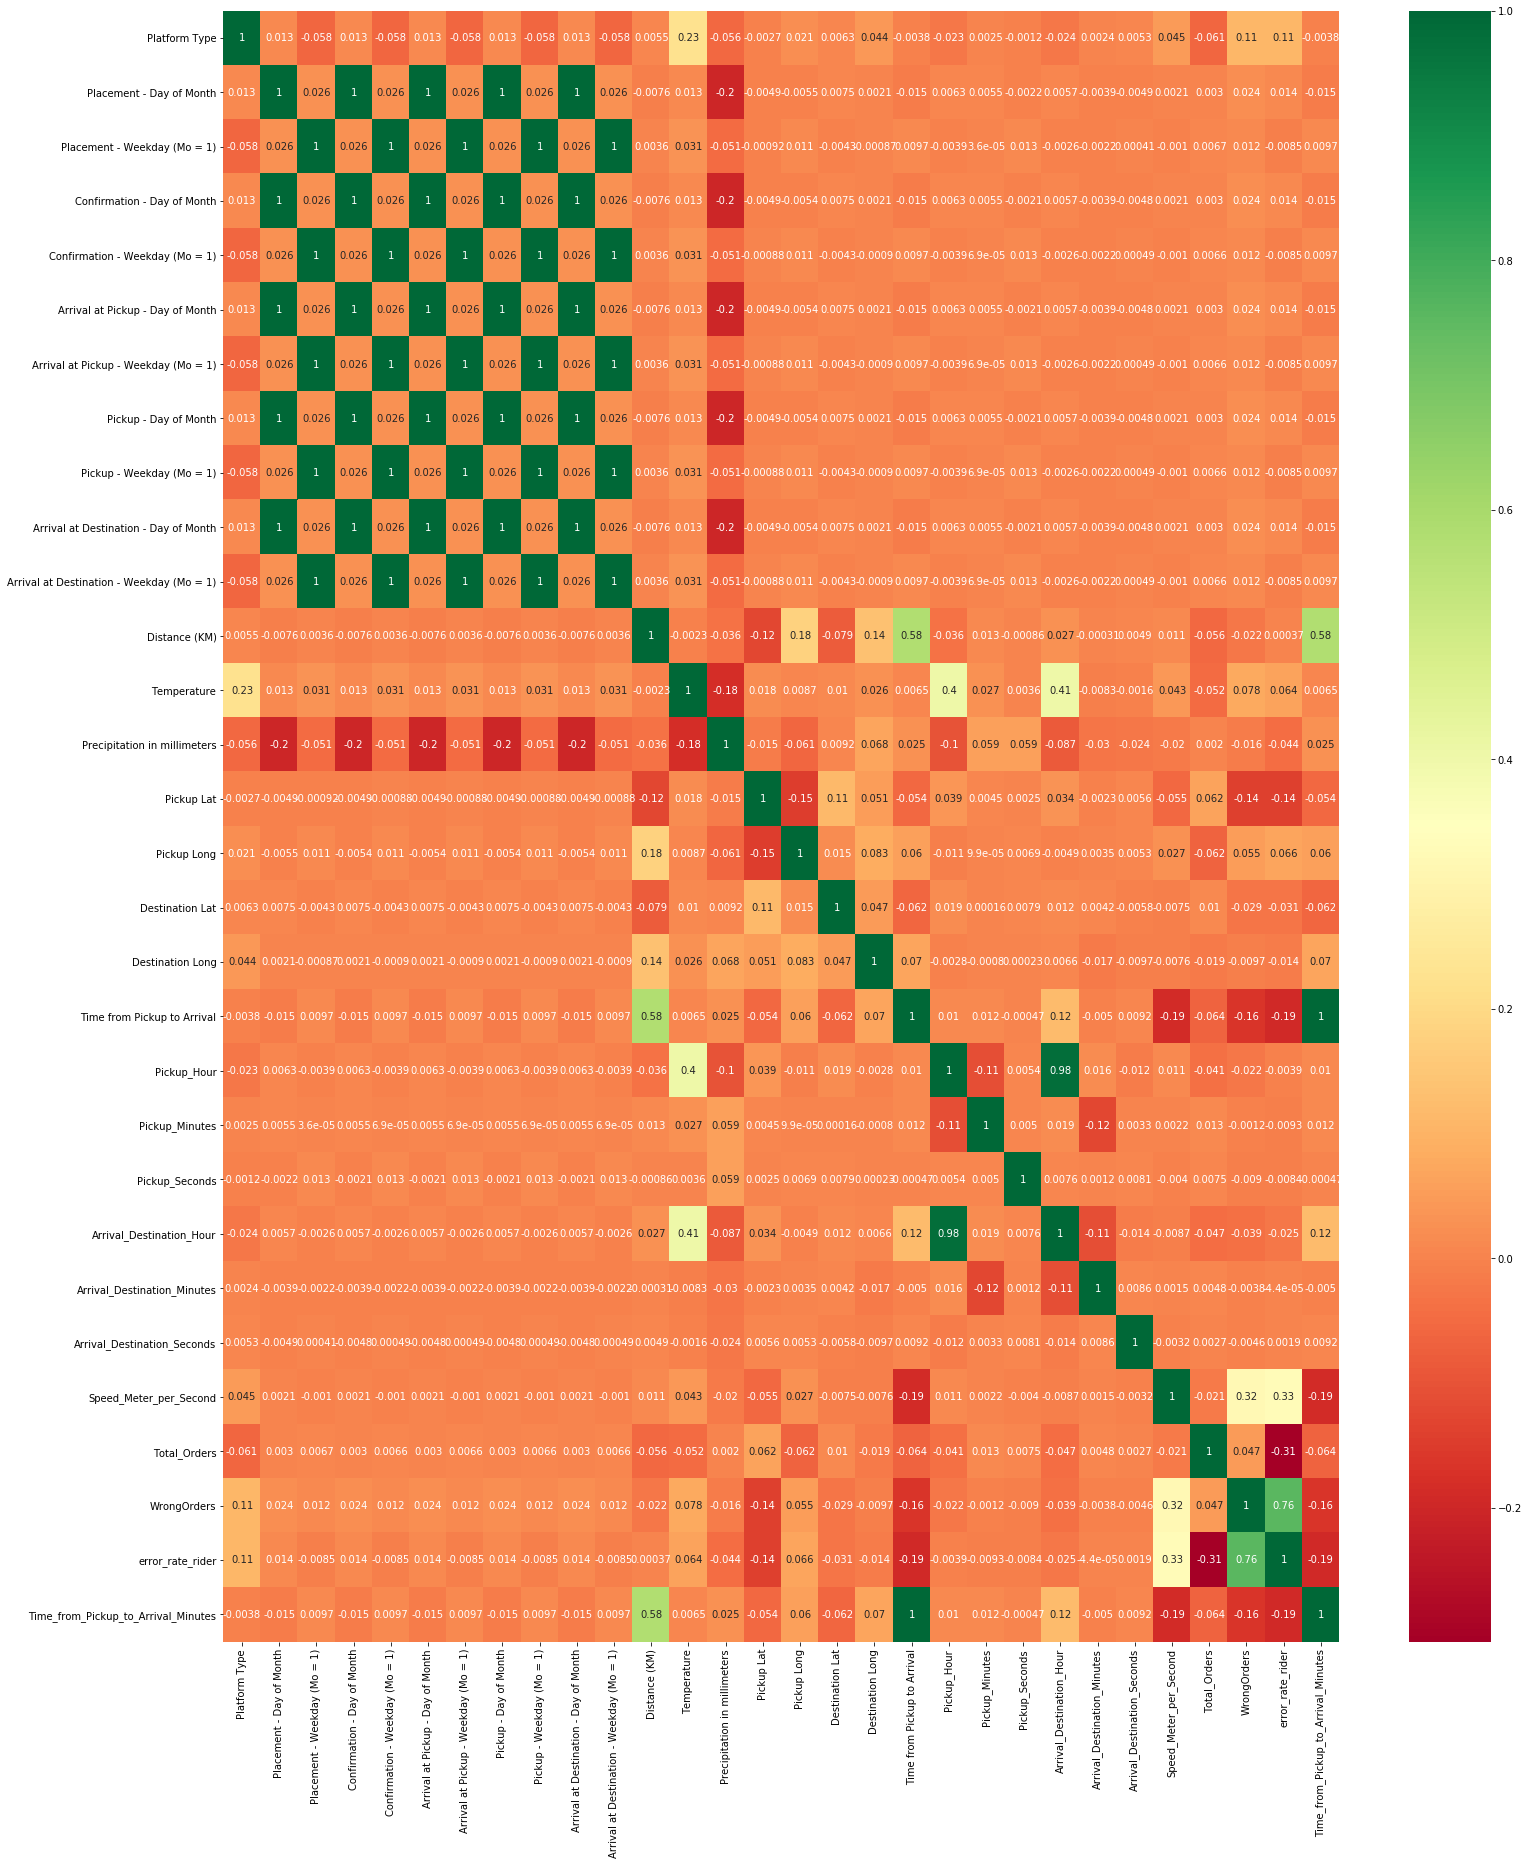

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
import seaborn as sns



corrmat = train.corr()
top_corr_features = corrmat.index
#plt.figure(figsize=(20,20))
rcParams['figure.figsize'] = 25, 30
#plot heat map
g=sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

There is a relatively high correlation (0.58) between 'Distance (KM)' and 'Time from Pickup to Arrival', as expected. Very high correlations exist between day of month for placement, confirmation, arrival at pickup, pickup and destination. Likewise, the same trend can be seen for weekday with each of these variables. Therefore, we can probably drop all of these variables and retain one each for day of month and day of week.   

## 6. Feature Engineering & Selection

Having a strong knowledge of the logistics domain, specifically involving motorbike deliveries, helps in the extraction of useful features from the raw data. The process of creating these new features is known as feature engineering. These features can be used to improve the performance of machine learning algorithms. 

Feature selection is the process of reducing the number of input variables when developing a predictive model. Where one predictor variable is highly correlated with another (e.g. 'Placement - Time' and 'Confirmation - Time') one of them should be filtered out to avoid the consequences of high multicollinearity. Apart from these instances, I also dropped vehicle type (since it only contained one unique value), User Id, platform and business/personal (since they did not contain useful information in terms of predictive capability). The Lasso model can be used to automatically filter out variables that are not significant predictors.

Some of the key variables which the author engineered are the following:
* Speed (metres per second)
* Average speed of each rider
* A rating factor for each rider (calculated by multipying their average rating by the number of ratings)
* Rider Productivity (calculated by dividing age by number of orders)
* Time intervals, for example, the interval between Arrival at Pickup and Pickup
* Weekend variable (calculated from Day of Week order was placed)
* Hour of pickup
* AM_PM variable (based on hour of pickup)
* Direction (based on combination of pickup latitude and longitude as well as destination latitude and longitude)
* Manhattan distance (also based on calculations using pickup and destination latitudes and longitudes)
* Specific rating (based on value in average rating column)
* Log-transformed distance (to transform skewed distribution into normal distribution)

In [44]:
train['ORIGIN_MOVEMENT_ID']=-1
train['DESTINATION_MOVEMENT_ID']=-1

In [45]:
test['ORIGIN_MOVEMENT_ID']=-1
test['DESTINATION_MOVEMENT_ID']=-1

In [46]:
train.drop(['Vehicle Type'],axis=1,inplace=True)
train.columns

Index(['Order No', 'User Id', 'Platform Type', 'Personal or Business',
       'Placement - Day of Month', 'Placement - Weekday (Mo = 1)',
       'Placement - Time', 'Confirmation - Day of Month',
       'Confirmation - Weekday (Mo = 1)', 'Confirmation - Time',
       'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Arrival at Destination - Day of Month',
       'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time', 'Distance (KM)', 'Temperature',
       'Precipitation in millimeters', 'Pickup Lat', 'Pickup Long',
       'Destination Lat', 'Destination Long', 'Rider Id',
       'Time from Pickup to Arrival', 'Pickup_Hour', 'Pickup_Minutes',
       'Pickup_Seconds', 'Arrival_Destination_Hour',
       'Arrival_Destination_Minutes', 'Arrival_Destination_Seconds',
       'Speed_Meter_per_Second', 'Total_Orders', 'Wr

In [47]:
train = pd.merge(train,riders,on='Rider Id',how='left')
test = pd.merge(test,riders,on='Rider Id',how='left')
train['Time_from_Pickup_to_Arrival_Minutes'] = train['Time from Pickup to Arrival']/60
train['Speed_Meter_per_Second'] = (train['Distance (KM)']*1000)/train['Time from Pickup to Arrival']
OutliersTrain = train[(train.Speed_Meter_per_Second>=21)]#|(train.Speed_Meter_per_Second<=2)]
OutlierFreeTrain = train[~(train['Order No'].isin(OutliersTrain['Order No']))]
riders['WrongOrders'] = riders['Rider Id'].map(OutliersTrain.groupby('Rider Id').agg('count')['Order No'])
riders.WrongOrders.fillna(value=0,inplace=True)
train['Total_Orders'] = train['Rider Id'].map(train.groupby('Rider Id').agg('count')['Order No'])
train = pd.merge(train,riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
test = pd.merge(test,riders.drop(['No_of_Ratings','Average_Rating','Age','No_Of_Orders'],axis=1),on='Rider Id',how='left')
train['Average_Rider_Speed'] = train['Rider Id'].map(OutlierFreeTrain.groupby('Rider Id').Speed_Meter_per_Second.mean())
test['Average_Rider_Speed'] =test['Rider Id'].map(OutlierFreeTrain.groupby('Rider Id').Speed_Meter_per_Second.mean())
train['error_rate_rider'] = train['WrongOrders']/train['Total_Orders']
test['WrongOrders'] = test['Rider Id'].map(riders.groupby('Rider Id').agg('sum').WrongOrders)
test['Total_Orders'] = test['Rider Id'].map(train.groupby('Rider Id').agg('count')['Order No'])
test['error_rate_rider'] = test.WrongOrders/test.Total_Orders
test.WrongOrders.fillna(value=train.WrongOrders.mean(),inplace=True)
test.error_rate_rider.fillna(value=train.error_rate_rider.mean(),inplace=True)
test.Total_Orders.fillna(value=0,inplace=True)
train.WrongOrders.fillna(value=train.WrongOrders.mean(),inplace=True)
train.error_rate_rider.fillna(value=train.error_rate_rider.mean(),inplace=True)
train.Total_Orders.fillna(value=0,inplace=True)
test.Average_Rider_Speed.fillna(value=OutlierFreeTrain.Speed_Meter_per_Second.mean(),inplace=True)

In [48]:
train['RatingFactor_Rider'] = train['Average_Rating']*train['No_of_Ratings']
test['RatingFactor_Rider'] = test['Average_Rating']*test['No_of_Ratings']
train['Productivity_Rider'] = train['Age']/train['No_Of_Orders']
test['Productivity_Rider'] = test['Age']/test['No_Of_Orders']

In [49]:
classifytrain = train.copy()
classifytest = test.copy()
classifytrain.rename({'Arrival at Destination - Day of Month':'Day_of_month','Arrival at Destination - Weekday (Mo = 1)':'Weekday'},axis=1,inplace=True)
classifytest.rename({'Arrival at Pickup - Day of Month':'Day_of_month','Arrival at Pickup - Weekday (Mo = 1)':'Weekday'},axis=1,inplace=True)
classifytrain['Confirmation - Time']=pd.to_datetime(classifytrain['Confirmation - Time'])
classifytrain['Placement - Time']=pd.to_datetime(classifytrain['Placement - Time'])
classifytrain['Pickup - Time'] = pd.to_datetime(classifytrain['Pickup - Time'])
classifytrain['Arrival at Pickup - Time'] = pd.to_datetime(classifytrain['Arrival at Pickup - Time'])
classifytest['Confirmation - Time']=pd.to_datetime(classifytest['Confirmation - Time'])
classifytest['Placement - Time']=pd.to_datetime(classifytest['Placement - Time'])
classifytest['Pickup - Time'] = pd.to_datetime(classifytest['Pickup - Time'])
classifytest['Arrival at Pickup - Time'] = pd.to_datetime(classifytest['Arrival at Pickup - Time'])
classifytrain['Placement_Time - Confirmation'] = (classifytrain['Confirmation - Time'] - classifytrain['Placement - Time']).astype('timedelta64[s]')
classifytrain['Confirmation - Arrival_Pickup'] = (classifytrain['Arrival at Pickup - Time']-classifytrain['Confirmation - Time']).astype('timedelta64[s]')
classifytrain['Arrival at Pickup - Pickup'] = (classifytrain['Pickup - Time']-classifytrain['Arrival at Pickup - Time']).astype('timedelta64[s]')
classifytest['Placement_Time - Confirmation'] = (classifytest['Confirmation - Time'] - classifytest['Placement - Time']).astype('timedelta64[s]')
classifytest['Confirmation - Arrival_Pickup'] = (classifytest['Arrival at Pickup - Time']-classifytest['Confirmation - Time']).astype('timedelta64[s]')
classifytest['Arrival at Pickup - Pickup'] = (classifytest['Pickup - Time']-classifytest['Arrival at Pickup - Time']).astype('timedelta64[s]')

In [50]:
## a tester avec classification et sans
train['Placement_Time - Confirmation'] = classifytrain['Placement_Time - Confirmation']
train['Confirmation - Arrival_Pickup'] = classifytrain['Confirmation - Arrival_Pickup']
train['Arrival at Pickup - Pickup'] = classifytrain['Arrival at Pickup - Pickup']
test['Placement_Time - Confirmation'] = classifytest['Placement_Time - Confirmation']
test['Confirmation - Arrival_Pickup'] = classifytest['Confirmation - Arrival_Pickup']
test['Arrival at Pickup - Pickup'] = classifytest['Arrival at Pickup - Pickup']

In [51]:
train['pos_pickup'] = train['Pickup Long'].apply(str)+'_'+train['Pickup Lat'].apply(str)
train['pos_dest'] = train['Destination Long'].apply(str)+'_'+train['Pickup Lat'].apply(str)
test['pos_pickup'] = test['Pickup Long'].apply(str)+'_'+test['Pickup Lat'].apply(str)
test['pos_dest'] = test['Destination Long'].apply(str)+'_'+test['Pickup Lat'].apply(str)
train['from_to']= train['pos_pickup']+'_'+train['pos_dest']
test['from_to']= test['pos_pickup']+'_'+test['pos_dest']

In [52]:
def not_weekend(x):
  if x<=5:
    return 1
  else :
    return 0
train["not_weekend"] = train["Placement - Weekday (Mo = 1)"].apply(not_weekend)
test["not_weekend"] = test["Placement - Weekday (Mo = 1)"].apply(not_weekend)

In [53]:
def quarter_of_month(x):
  if x>=1 and x<=7:
    return 1
  elif x>7 and x<=14:
    return 2
  elif x>14 and x<=21:
    return 3
  else:
    return 4
train["Placement - Day of Month_quarter_of_month"] = train["Placement - Day of Month"].apply(quarter_of_month)
test["Placement - Day of Month_quarter_of_month"] = test["Placement - Day of Month"].apply(quarter_of_month) 

In [54]:
train['Pickup - Time'] = pd.to_datetime(train['Pickup - Time'])
test['Pickup - Time'] = pd.to_datetime(test['Pickup - Time'])
train['Pickup_Hour'] = train['Pickup - Time'].dt.hour
test['Pickup_Hour'] = test['Pickup - Time'].dt.hour

In [55]:
"""
train.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
train.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<=11),'DayTime']= 'Matin'
train.loc[(train['Pickup_Hour']>11)&(train['Pickup_Hour']<=13),'DayTime']= '9ayla'
train.loc[(train['Pickup_Hour']>13)&(train['Pickup_Hour']<17),'DayTime']= 'ApresMidi'
train.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'
train.loc[(train['Pickup_Hour']>19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'
test.loc[(test['Pickup_Hour']>=7)&(test['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
test.loc[(test['Pickup_Hour']>=9)&(test['Pickup_Hour']<=11),'DayTime']= 'Matin'
test.loc[(test['Pickup_Hour']>11)&(test['Pickup_Hour']<=13),'DayTime']= '9ayla'
test.loc[(test['Pickup_Hour']>13)&(test['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'
test.loc[(test['Pickup_Hour']>13)&(test['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'
test.loc[(test['Pickup_Hour']>16)&(test['Pickup_Hour']<=21),'DayTime']= 'Night'
test.loc[(test['Pickup_Hour']>=17)&(test['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'
"""

"\ntrain.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'\ntrain.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<=11),'DayTime']= 'Matin'\ntrain.loc[(train['Pickup_Hour']>11)&(train['Pickup_Hour']<=13),'DayTime']= '9ayla'\ntrain.loc[(train['Pickup_Hour']>13)&(train['Pickup_Hour']<17),'DayTime']= 'ApresMidi'\ntrain.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'\ntrain.loc[(train['Pickup_Hour']>19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'\ntest.loc[(test['Pickup_Hour']>=7)&(test['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'\ntest.loc[(test['Pickup_Hour']>=9)&(test['Pickup_Hour']<=11),'DayTime']= 'Matin'\ntest.loc[(test['Pickup_Hour']>11)&(test['Pickup_Hour']<=13),'DayTime']= '9ayla'\ntest.loc[(test['Pickup_Hour']>13)&(test['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'\ntest.loc[(test['Pickup_Hour']>13)&(test['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'\ntest.loc[(test['Pickup_Hour']>16)&(test['Pickup_Hour']<=21),'DayTim

In [56]:
train.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
train.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<=11),'DayTime']= 'Matin'
train.loc[(train['Pickup_Hour']>11)&(train['Pickup_Hour']<=13),'DayTime']= '9ayla'
train.loc[(train['Pickup_Hour']>13)&(train['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'
train.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'
train.loc[(train['Pickup_Hour']>19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'
test.loc[(test['Pickup_Hour']>=7)&(test['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
test.loc[(test['Pickup_Hour']>=9)&(test['Pickup_Hour']<=11),'DayTime']= 'Matin'
test.loc[(test['Pickup_Hour']>11)&(test['Pickup_Hour']<=13),'DayTime']= '9ayla'
test.loc[(test['Pickup_Hour']>13)&(test['Pickup_Hour']<=16),'DayTime']= 'ApresMidi'
test.loc[(test['Pickup_Hour']>=17)&(test['Pickup_Hour']<=19),'DayTime']= 'Rush_Hour2'
test.loc[(test['Pickup_Hour']>19)&(test['Pickup_Hour']<7),'DayTime']= 'Night'

In [57]:
"""
train.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
train.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<11),'DayTime']= 'Matin'
train.loc[(train['Pickup_Hour']>=11)&(train['Pickup_Hour']<13),'DayTime']= '9ayla'
train.loc[(train['Pickup_Hour']>=13)&(train['Pickup_Hour']<17),'DayTime']= 'ApresMidi'
train.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<19),'DayTime']= 'Rush_Hour2'
train.loc[(train['Pickup_Hour']>=19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'
test.loc[(test['Pickup_Hour']>=7)&(test['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'
test.loc[(test['Pickup_Hour']>=9)&(test['Pickup_Hour']<11),'DayTime']= 'Matin'
test.loc[(test['Pickup_Hour']>=11)&(test['Pickup_Hour']<13),'DayTime']= '9ayla'
test.loc[(test['Pickup_Hour']>=13)&(test['Pickup_Hour']<17),'DayTime']= 'ApresMidi'
test.loc[(test['Pickup_Hour']>=17)&(test['Pickup_Hour']<19),'DayTime']= 'Rush_Hour2'
test.loc[(test['Pickup_Hour']>19)&(test['Pickup_Hour']<7),'DayTime']= 'Night'
"""

"\ntrain.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'\ntrain.loc[(train['Pickup_Hour']>=9)&(train['Pickup_Hour']<11),'DayTime']= 'Matin'\ntrain.loc[(train['Pickup_Hour']>=11)&(train['Pickup_Hour']<13),'DayTime']= '9ayla'\ntrain.loc[(train['Pickup_Hour']>=13)&(train['Pickup_Hour']<17),'DayTime']= 'ApresMidi'\ntrain.loc[(train['Pickup_Hour']>=17)&(train['Pickup_Hour']<19),'DayTime']= 'Rush_Hour2'\ntrain.loc[(train['Pickup_Hour']>=19)&(train['Pickup_Hour']<7),'DayTime']= 'Night'\ntest.loc[(test['Pickup_Hour']>=7)&(test['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'\ntest.loc[(test['Pickup_Hour']>=9)&(test['Pickup_Hour']<11),'DayTime']= 'Matin'\ntest.loc[(test['Pickup_Hour']>=11)&(test['Pickup_Hour']<13),'DayTime']= '9ayla'\ntest.loc[(test['Pickup_Hour']>=13)&(test['Pickup_Hour']<17),'DayTime']= 'ApresMidi'\ntest.loc[(test['Pickup_Hour']>=17)&(test['Pickup_Hour']<19),'DayTime']= 'Rush_Hour2'\ntest.loc[(test['Pickup_Hour']>19)&(test['Pickup_Hour']<7),'DayTime'

In [58]:
train.rename({"ORIGIN_MOVEMENT_ID":"sourceid","DESTINATION_MOVEMENT_ID":"dstid","Pickup_Hour":"hod"},inplace=True,axis=1)
test.rename({"ORIGIN_MOVEMENT_ID":"sourceid","DESTINATION_MOVEMENT_ID":"dstid","Pickup_Hour":"hod"},inplace=True,axis=1)

In [59]:
data = [train, test]
for dataset in data:
    dataset.loc[ (dataset['hod'] < 13) , 'AM_PM'] = 'AM'
    dataset.loc[(dataset['hod'] >= 13) , 'AM_PM'] = 'PM'

In [60]:
train['Daytime_Day'] = train['DayTime']+'_'+train['Placement - Weekday (Mo = 1)'].apply(str)
test['Daytime_Day'] = test['DayTime']+'_'+test['Placement - Weekday (Mo = 1)'].apply(str)

In [61]:
train.loc[:, 'center_latitude'] = (train['Pickup Lat'].values + train['Destination Lat'].values) / 2
train.loc[:, 'center_longitude'] = (train['Pickup Long'].values + train['Destination Long'].values) / 2
test.loc[:, 'center_latitude'] = (test['Pickup Lat'].values + test['Destination Lat'].values) / 2
test.loc[:, 'center_longitude'] = (test['Pickup Long'].values + test['Destination Long'].values) / 2

In [62]:
coords = np.vstack((train[['Pickup Lat', 'Pickup Long']].values,
                    train[['Destination Lat', 'Destination Long']].values))

In [63]:
from sklearn.decomposition import PCA
pca = PCA(random_state=50).fit(coords)
train['pickup_pca0'] = pca.transform(train[['Pickup Lat', 'Pickup Long']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['Pickup Lat', 'Pickup Long']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['Destination Lat', 'Destination Long']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['Destination Lat', 'Destination Long']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['Pickup Lat', 'Pickup Long']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['Pickup Lat', 'Pickup Long']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['Destination Lat', 'Destination Long']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['Destination Lat', 'Destination Long']])[:, 1]

In [64]:
from sklearn.cluster import MiniBatchKMeans
sample_ind = np.arange(start=0, stop=len(coords), step=1)
kmeans = MiniBatchKMeans(n_clusters=14, batch_size=11000,random_state=50).fit(coords[sample_ind])
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['Pickup Lat', 'Pickup Long']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['Destination Lat', 'Destination Long']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['Pickup Lat', 'Pickup Long']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['Destination Lat', 'Destination Long']])

In [65]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [66]:
train.loc[:, 'direction'] = bearing_array(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'direction'] = bearing_array(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)

In [67]:
train["Rating13"] = train["Average_Rating"].apply(lambda x:1 if x>=13 and x<14 else 0)
train["Rating14"] = train["Average_Rating"].apply(lambda x:1 if x>=14 and x<15 else 0)
train["Rating15+"] = train["Average_Rating"].apply(lambda x:1 if x>=15 else 0)
train["Rating_Under_11"] = train["Average_Rating"].apply(lambda x:1 if x<11 else 0)
train["Rating_between_11_12"] = train["Average_Rating"].apply(lambda x:1 if x>=11 and x<13 else 0)

test["Rating13"] = test["Average_Rating"].apply(lambda x:1 if x>=13 and x<14 else 0)
test["Rating14"] = test["Average_Rating"].apply(lambda x:1 if x>=14 and x<15 else 0)
test["Rating15+"] = test["Average_Rating"].apply(lambda x:1 if x>=15 else 0)
test["Rating_Under_11"] = test["Average_Rating"].apply(lambda x:1 if x<11 else 0)
test["Rating_between_11_12"] = test["Average_Rating"].apply(lambda x:1 if x>=11 and x<13 else 0)

In [68]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b
train.loc[:, 'distance_haversine'] = haversine_array(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)


In [69]:
train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['Pickup Lat'].values, train['Pickup Long'].values, train['Destination Lat'].values, train['Destination Long'].values)
test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['Pickup Lat'].values, test['Pickup Long'].values, test['Destination Lat'].values, test['Destination Long'].values)

In [70]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['Pickup Lat'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['Pickup Long'], 2)
train.loc[:, 'dest_lat_bin'] = np.round(train['Destination Lat'],2)
train.loc[:, 'dest_long_bin'] = np.round(train['Destination Long'], 2)
test.loc[:, 'pickup_lat_bin'] = np.round(test['Pickup Lat'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['Pickup Long'], 2)
test.loc[:, 'dest_lat_bin'] = np.round(test['Destination Lat'], 2)
test.loc[:, 'dest_long_bin'] = np.round(test['Destination Long'], 2)

In [71]:
train['Pickup - Time'] = pd.to_datetime(train['Pickup - Time'])
test['Pickup - Time'] = pd.to_datetime(test['Pickup - Time'])
train['Pickup_Hour'] = train['Pickup - Time'].dt.hour
test['Pickup_Hour'] = test['Pickup - Time'].dt.hour

In [72]:
train['Confirmation - Time'] = pd.to_datetime(train['Confirmation - Time'])
test['Confirmation - Time'] = pd.to_datetime(test['Confirmation - Time'])
train['Confirmation_Hour'] = train['Confirmation - Time'].dt.hour
test['Confirmation_Hour'] = test['Confirmation - Time'].dt.hour

In [73]:
hours_in_day = 24

train['sin_hour_pickup'] = np.sin(2*np.pi*train.Pickup_Hour/hours_in_day)
train['cos_hour_pickup'] = np.cos(2*np.pi*train.Pickup_Hour/hours_in_day)
test['sin_hour_pickup'] = np.sin(2*np.pi*test.Pickup_Hour/hours_in_day)
test['cos_hour_pickup'] = np.cos(2*np.pi*test.Pickup_Hour/hours_in_day)

In [74]:
hours_in_day = 24

train['sin_hour_confirmation'] = np.sin(2*np.pi*train.Pickup_Hour/hours_in_day)
train['cos_hour_confirmation'] = np.cos(2*np.pi*train.Pickup_Hour/hours_in_day)
test['sin_hour_confirmation'] = np.sin(2*np.pi*test.Pickup_Hour/hours_in_day)
test['cos_hour_confirmation'] = np.cos(2*np.pi*test.Pickup_Hour/hours_in_day)

In [75]:
test.tail()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,pickup_lat_bin,pickup_long_bin,dest_lat_bin,dest_long_bin,Pickup_Hour,Confirmation_Hour,sin_hour_pickup,cos_hour_pickup,sin_hour_confirmation,cos_hour_confirmation
7063,Order_No_3612,User_Id_2587,Bike,3,Business,7,1,10:35:49 AM,7,1,...,-1.26,36.80,-1.29,36.82,10,10,0.500000,-0.866025,0.500000,-0.866025
7064,Order_No_7657,User_Id_3547,Bike,3,Business,10,3,2:59:42 PM,10,3,...,-1.28,36.77,-1.32,36.91,15,15,-0.707107,-0.707107,-0.707107,-0.707107
7065,Order_No_1969,User_Id_136,Bike,3,Business,5,3,2:45:12 PM,5,3,...,-1.30,36.77,-1.26,36.80,15,14,-0.707107,-0.707107,-0.707107,-0.707107
7066,Order_No_10591,User_Id_1979,Bike,3,Personal,29,2,3:18:26 PM,29,2,...,-1.25,36.68,-1.27,36.82,15,15,-0.707107,-0.707107,-0.707107,-0.707107
7067,Order_No_1603,User_Id_1721,Bike,3,Business,4,2,3:37:09 PM,4,2,...,-1.26,36.78,-1.30,36.83,16,15,-0.866025,-0.500000,-0.866025,-0.500000


In [76]:
def haversine_dist(lat1,lng1,lat2,lng2):
  lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
  radius = 6371  # Earth's radius taken from google
  lat = lat2 - lat1
  lng = lng2 - lng1
  d = np.sin(lat/2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng/2) ** 2
  h = 2 * radius * np.arcsin(np.sqrt(d))
  return h

In [77]:
#train.drop(['mean_travel_time','standard_deviation_travel_time'],axis=1,inplace=True)
#test.drop(['mean_travel_time','standard_deviation_travel_time'],axis=1,inplace=True)

In [78]:
error_mean=train.error_rate_rider.mean()
train.loc[(train.error_rate_rider>=0.2)&(train.Total_Orders<=5),'error_rate_rider']=error_mean
test.loc[(test.error_rate_rider>=0.2)&(test.Total_Orders<=5),'error_rate_rider']=error_mean

In [79]:
#train.rename({'mean_travel_time':'mean_travel_time_y','standard_deviation_travel_time':'standard_deviation_travel_time_y'},axis=1,inplace=True)
#test.rename({'mean_travel_time':'mean_travel_time_y','standard_deviation_travel_time':'standard_deviation_travel_time_y'},axis=1,inplace=True)

In [80]:
#train.drop(['mean_travel_time','standard_deviation_travel_time'],axis=1,inplace=True)
#test.drop(['mean_travel_time','standard_deviation_travel_time'],axis=1,inplace=True)

In [81]:
train=train[train['Time from Pickup to Arrival']<=5000]

In [82]:
#FILTER OUT 240,180,120,60,30,NONE

In [83]:
#train=train[train['Time from Pickup to Arrival']>=30]

In [84]:
#ADDING DISTANCE (KM) BELOW TO SEE IMPACT

In [85]:
#TRY LOG DISTANCE

In [86]:
#HAVE 2 COLS - DISTANCE AND LOG DISTANCE

In [87]:
train['Distance (KM)_Log'] = np.log1p(train['Distance (KM)'])
train['Distance (KM)_Log']

C:\Users\mwaters\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        1.609438
1        2.833213
2        1.386294
3        2.302585
4        2.302585
           ...   
21196    1.386294
21197    2.079442
21198    3.044522
21199    2.639057
21200    2.564949
Name: Distance (KM)_Log, Length: 21090, dtype: float64

In [88]:
#np.exp(train['Distance (KM)'])
np.exp(train['Distance (KM)_Log'])

0         5.0
1        17.0
2         4.0
3        10.0
4        10.0
         ... 
21196     4.0
21197     8.0
21198    21.0
21199    14.0
21200    13.0
Name: Distance (KM)_Log, Length: 21090, dtype: float64

In [89]:
test['Distance (KM)_Log'] = np.log1p(test['Distance (KM)'])
test['Distance (KM)_Log']

0       2.197225
1       1.791759
2       1.791759
3       1.791759
4       1.945910
          ...   
7063    1.791759
7064    3.135494
7065    2.397895
7066    2.944439
7067    2.197225
Name: Distance (KM)_Log, Length: 7068, dtype: float64

In [90]:
#TRY GEOPY FUNCTION

In [91]:
from geopy import distance

In [92]:
def compute_distance(row):
    src = (row['Pickup Lat'], row['Pickup Long'])
    dest = (row['Destination Lat'], row['Destination Long'])
    return distance.distance(src,dest).km

In [93]:
train['geopy_distance'] = train.apply(compute_distance, axis=1)
test['geopy_distance'] = test.apply(compute_distance, axis=1)

C:\Users\mwaters\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
train['geopy_distance']

0         1.919586
1        11.329354
2         1.879806
3         4.939253
4         3.711035
           ...    
21196     1.879986
21197     3.722621
21198    10.762430
21199     9.396242
21200     8.997893
Name: geopy_distance, Length: 21090, dtype: float64

In [95]:
# NOW TRY ADD GEOPY LOG AS WELL 

In [96]:
train['geopy_distance_log'] = np.log1p(train['geopy_distance'])
train['geopy_distance_log']

C:\Users\mwaters\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        1.071442
1        2.511983
2        1.057723
3        1.781583
4        1.549908
           ...   
21196    1.057786
21197    1.552364
21198    2.464911
21199    2.341444
21200    2.302374
Name: geopy_distance_log, Length: 21090, dtype: float64

In [97]:
test['geopy_distance_log'] = np.log1p(test['geopy_distance'])
test['geopy_distance_log']

0       1.976394
1       1.454802
2       1.511719
3       1.266458
4       1.375726
          ...   
7063    1.529270
7064    2.857501
7065    1.853844
7066    2.815613
7067    2.113759
Name: geopy_distance_log, Length: 7068, dtype: float64

In [98]:
#TRY DELETE PLATFORM AND PERS/BUS

In [99]:
#TRY DROP ROWS W RAIN FROM TRAIN


In [100]:
#INCLUDE TEMPERATURE

In [101]:
train['Temperature'].isnull().sum()

4346

In [102]:
test['Temperature'].isnull().sum()

1437

In [103]:
train['Temperature'] = train['Temperature'].fillna(train['Temperature'].mean())

C:\Users\mwaters\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
test['Temperature'] = test['Temperature'].fillna(test['Temperature'].mean())

In [105]:
train['Temperature'].mean()

23.256605351170354

In [106]:
test['Temperature'].mean()

23.246119694548558

In [107]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21090 entries, 0 to 21200
Data columns (total 90 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Order No                                   21090 non-null  object        
 1   User Id                                    21090 non-null  object        
 2   Platform Type                              21090 non-null  int64         
 3   Personal or Business                       21090 non-null  object        
 4   Placement - Day of Month                   21090 non-null  int64         
 5   Placement - Weekday (Mo = 1)               21090 non-null  int64         
 6   Placement - Time                           21090 non-null  object        
 7   Confirmation - Day of Month                21090 non-null  int64         
 8   Confirmation - Weekday (Mo = 1)            21090 non-null  int64         
 9   Confirmation - Ti

In [108]:
#ADD SPEED VARIABLE - abandoned this idea because I don;t have Time (iot calc speed) in test set

In [109]:
#create feature speed in sendy dataset
#train['speed'] = train['Distance (KM)'] / train['Time from Pickup to Arrival']
#train.head().T

In [110]:
##MAP TIME TO MORNING, AFTERNOON, EVENING

In [111]:
train['Pickup_Hour']

0        10
1        11
2        12
3         9
4        10
         ..
21196    16
21197    10
21198    17
21199     9
21200    14
Name: Pickup_Hour, Length: 21090, dtype: int64

In [112]:
train['DayTime']

0             Matin
1             Matin
2             9ayla
3             Matin
4             Matin
            ...    
21196     ApresMidi
21197         Matin
21198    Rush_Hour2
21199         Matin
21200     ApresMidi
Name: DayTime, Length: 21090, dtype: object

In [113]:
train['Daytime_Day']

0             Matin_5
1             Matin_5
2             9ayla_2
3             Matin_5
4             Matin_1
             ...     
21196     ApresMidi_3
21197         Matin_6
21198    Rush_Hour2_4
21199         Matin_3
21200     ApresMidi_2
Name: Daytime_Day, Length: 21090, dtype: object

In [114]:
train[train['Pickup_Hour'] > 19]

,Order No,User Id,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Confirmation - Time,...,dest_long_bin,Pickup_Hour,Confirmation_Hour,sin_hour_pickup,cos_hour_pickup,sin_hour_confirmation,cos_hour_confirmation,Distance (KM)_Log,geopy_distance,geopy_distance_log
99,Order_No_20962,User_Id_3544,2,Personal,18,5,6:52:38 PM,18,5,2021-03-15 19:28:20,...,36.79,20,19,-0.866025,0.500000,-0.866025,0.500000,1.609438,2.274084,1.186038
461,Order_No_7076,User_Id_173,3,Business,21,5,9:07:53 PM,21,5,2021-03-15 21:08:16,...,36.79,21,21,-0.707107,0.707107,-0.707107,0.707107,1.945910,4.199842,1.648628
536,Order_No_19743,User_Id_2924,3,Personal,2,3,7:59:49 PM,2,3,2021-03-15 20:07:42,...,36.80,21,20,-0.707107,0.707107,-0.707107,0.707107,2.397895,6.255559,1.981768
611,Order_No_7277,User_Id_302,3,Business,11,1,8:05:01 PM,11,1,2021-03-15 20:06:04,...,36.82,20,20,-0.866025,0.500000,-0.866025,0.500000,2.197225,6.169424,1.969825
663,Order_No_12066,User_Id_302,3,Business,21,5,8:27:20 PM,21,5,2021-03-15 20:37:55,...,36.82,21,20,-0.707107,0.707107,-0.707107,0.707107,1.386294,2.615908,1.285343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20776,Order_No_8830,User_Id_302,3,Business,13,2,8:22:07 PM,13,2,2021-03-15 20:22:39,...,36.78,20,20,-0.866025,0.500000,-0.866025,0.500000,2.079442,3.736013,1.555196
20961,Order_No_27935,User_Id_3001,3,Business,22,4,7:57:37 PM,22,4,2021-03-15 20:28:32,...,36.78,20,20,-0.866025,0.500000,-0.866025,0.500000,1.791759,2.189799,1.159958
21028,Order_No_18024,User_Id_302,3,Business,24,7,8:50:55 PM,24,7,2021-03-15 20:51:15,...,36.80,21,20,-0.707107,0.707107,-0.707107,0.707107,1.098612,0.606225,0.473887
21051,Order_No_19872,User_Id_2330,1,Business,25,2,8:27:44 PM,25,2,2021-03-15 20:27:58,...,36.81,20,20,-0.866025,0.500000,-0.866025,0.500000,1.945910,4.584386,1.719974


In [115]:
#train.loc[(train['Pickup_Hour']>=7)&(train['Pickup_Hour']<9),'DayTime']= 'Rush_Hour1'

In [116]:
features1 = [#'Platform Type', 'Personal or Business', #'Total_Population',
    'hod',
    'Pickup - Weekday (Mo = 1)',    
    'not_weekend',
        #'Placement - Day of Month_quarter_of_month',
        'distance_manhattan',
       'distance_haversine', 
        'Distance (KM)', 'Distance (KM)_Log', 
        'geopy_distance', 'geopy_distance_log', 'Daytime_Day', 
             'Temperature',
        'Rider Id','DayTime','AM_PM',# 'pos_pickup','pos_dest',
             #'cluster_to_cluster',#'from_to',
             #'Destination_Distance_To_Nairobi_Center','Pickup_Distance_To_Nairobi_Center',
       #'Pickup_Distance_To_Wilson','Pickup_Distance_To_Jogoo_Road',
             #'Pickup_Distance_To_Langata_Road','Pickup_Distance_To_Ngong_Road',
      #'Destination_Distance_To_Wilson','Destination_Distance_To_Jogoo_Road',
           #'Destination_Distance_To_Langata_Road', 'Destination_Distance_To_Ngong_Road',
             #'Pickup_Distance_To_JK','Destination_Distance_To_JK',
             #'Pickup_Distance_To_Parklands',#'Destination_Distance_To_Parklands',
        #'User Id',
        'No_Of_Orders', 'Age', 'Average_Rating', 'No_of_Ratings',
       'WrongOrders',  
        'Pickup Lat','Pickup Long','Destination Lat','Destination Long' ,    
       'error_rate_rider','RatingFactor_Rider', 'Productivity_Rider','Average_Rider_Speed',
        'Placement_Time - Confirmation', 'Confirmation - Arrival_Pickup',
       'Arrival at Pickup - Pickup',#'Distance-Minimum Distance',
             #'pickup_pca0', 'pickup_pca1','dropoff_pca0', 'dropoff_pca1',
       'center_latitude', 'center_longitude',
    'pickup_cluster', 'dropoff_cluster',
    'direction',
        'Rating13', 'Rating14', 'Rating15+', 'Rating_Under_11', 'Rating_between_11_12',
             #'mean_travel_time_x',
             #'mean_travel_time_y','standard_deviation_travel_time_y',
 'cos_hour_pickup','sin_hour_pickup']
  #'openroute_duration',
             #'standard_deviation_travel_time_x'
              #'distance_Departure_from_poly_1',
 #'distance_Arrival_from_poly_1',
  #'distance_Departure_from_poly_2',
 #'distance_Arrival_from_poly_2',
  #'distance_Departure_from_poly_3',
 #'distance_Arrival_from_poly_3',
  #'distance_Departure_from_poly_4',
 #'distance_Arrival_from_poly_4',
 
 #'distance_Departure_from_poly_21',
 #'distance_Arrival_from_poly_21',
 #'distance_Departure_from_poly_22',
 #'distance_Arrival_from_poly_22',
 #'distance_Departure_from_poly_23',
 #'distance_Arrival_from_poly_23',
 #'distance_Departure_from_poly_24',
 #'distance_Arrival_from_poly_24',
 #'distance_Departure_from_poly_25',
 #'distance_Arrival_from_poly_25',
 #'distance_Departure_from_poly_26',
 #'distance_Arrival_from_poly_26',
 #'distance_Departure_from_poly_27',
 #'distance_Arrival_from_poly_27',
 #'distance_Departure_from_poly_28',
 #'distance_Arrival_from_poly_28',



 #'distance_Departure_from_poly_50',
 #'distance_Arrival_from_poly_50',
 #'distance_Departure_from_poly_51',
 #'distance_Arrival_from_poly_51',
 #'distance_Departure_from_poly_52',
 #'distance_Arrival_from_poly_52',
 #'distance_Departure_from_poly_53',
 #'distance_Arrival_from_poly_53',
 #'distance_Departure_from_poly_54',
 #'distance_Arrival_from_poly_54',
 #'distance_Departure_from_poly_55',
 #'distance_Arrival_from_poly_55',
 #'distance_Departure_from_poly_56',
 #'distance_Arrival_from_poly_56',
 #'distance_Departure_from_poly_57',
 #'distance_Arrival_from_poly_57',
 #'distance_Departure_from_poly_58',
 #'distance_Arrival_from_poly_58',
 #'distance_Departure_from_poly_59',
 #'distance_Arrival_from_poly_59',
 #'distance_Departure_from_poly_60',
 #'distance_Arrival_from_poly_60',
 #'distance_Departure_from_poly_61',
 #'distance_Arrival_from_poly_61',
 #'distance_Departure_from_poly_62',
 #'distance_Arrival_from_poly_62',
 #'distance_Departure_from_poly_63',
 #'distance_Arrival_from_poly_63',
 #'distance_Departure_from_poly_64',
 #'distance_Arrival_from_poly_64',
 #'distance_Departure_from_poly_65',
 #'distance_Arrival_from_poly_65',
 #'distance_Departure_from_poly_66',
 #'distance_Arrival_from_poly_66',
 #'distance_Departure_from_poly_67',
 #'distance_Arrival_from_poly_67',
 #'distance_Departure_from_poly_68',
 #'distance_Arrival_from_poly_68',
 #'distance_Departure_from_poly_69',
 #'distance_Arrival_from_poly_69',
 #'distance_Departure_from_poly_70',
 #'distance_Arrival_from_poly_70',
 #'distance_Departure_from_poly_71',
 #'distance_Arrival_from_poly_71',
 #'distance_Departure_from_poly_72',
 #'distance_Arrival_from_poly_72',
 #'distance_Departure_from_poly_73',
 #'distance_Arrival_from_poly_73',
 #'distance_Departure_from_poly_74',
 #'distance_Arrival_from_poly_74',
 #'distance_Departure_from_poly_75',
 #'distance_Arrival_from_poly_75',
 #'distance_Departure_from_poly_76',
 #'distance_Arrival_from_poly_76',
 #'distance_Departure_from_poly_77',
 #'distance_Arrival_from_poly_77',
 #'distance_Departure_from_poly_78',
 #'distance_Arrival_from_poly_78',
 #'distance_Departure_from_poly_79',
 #'distance_Arrival_from_poly_79',

 #'distance_Departure_from_poly_93',
 #'distance_Arrival_from_poly_93',
 #'distance_Departure_from_poly_94',
 #'distance_Arrival_from_poly_94',
 #'distance_Departure_from_poly_95',
 #'distance_Arrival_from_poly_95',
 #'distance_Departure_from_poly_96',
 #'distance_Arrival_from_poly_96',
 #'distance_Departure_from_poly_97',
 #'distance_Arrival_from_poly_97',
 #'distance_Departure_from_poly_98',
 #'distance_Arrival_from_poly_98',
 #'distance_Departure_from_poly_99',
 #'distance_Arrival_from_poly_99',
 #'distance_Departure_from_poly_100',
 #'distance_Arrival_from_poly_100',
 #'distance_Departure_from_poly_101',
 #'distance_Arrival_from_poly_101',
 #'distance_Departure_from_poly_102',
 #'distance_Arrival_from_poly_102',
 #'distance_Departure_from_poly_103',
 #'distance_Arrival_from_poly_103',
 #'distance_Departure_from_poly_104',
 #'distance_Arrival_from_poly_104',
 #'distance_Departure_from_poly_106',
 #'distance_Arrival_from_poly_106']

In [117]:
train ['Placement - Day of Month_quarter_of_month'].nunique()

4

In [118]:
#oce = ce.OneHotEncoder(cols=['Platform Type','Personal or Business','DayTime'])#,'AM_PM'])#,'Daytime_Day'])
oce = ce.OneHotEncoder(cols=['DayTime', 'not_weekend', 'AM_PM', 'Daytime_Day'])#,'AM_PM'])#,'Daytime_Day'])
hce = ce.TargetEncoder(cols=['Rider Id'],smoothing=40,min_samples_leaf=7)
X = train[features1]
y = train['Time from Pickup to Arrival']
X_test = test[features1]
X = oce.fit_transform(X)
X = hce.fit_transform(X,y)
X_test = oce.transform(X_test)
X_test = hce.transform(X_test)
X.Average_Rider_Speed.fillna(value=X["Average_Rider_Speed"].mean(),inplace=True)
X_test.Average_Rider_Speed.fillna(value=X["Average_Rider_Speed"].mean(),inplace=True)
#X.mean_travel_time_y.fillna(value=X["mean_travel_time_y"].mean(),inplace=True)
#X_test.mean_travel_time_y.fillna(value=X["mean_travel_time_y"].mean(),inplace=True)
#X.standard_deviation_travel_time_y.fillna(value=X["standard_deviation_travel_time_y"].mean(),inplace=True)
#X_test.standard_deviation_travel_time_y.fillna(value=X["standard_deviation_travel_time_y"].mean(),inplace=True)

#X.geometric_standard_deviation_travel_time_y.fillna(value=X["geometric_standard_deviation_travel_time_y"].mean(),inplace=True)
#X_test.geometric_standard_deviation_travel_time_y.fillna(value=X_test["geometric_standard_deviation_travel_time_y"].mean(),inplace=True)
#X.geometric_mean_travel_time_y.fillna(value=X["geometric_mean_travel_time_y"].mean(),inplace=True)
#X_test.geometric_mean_travel_time_y.fillna(value=X_test["geometric_mean_travel_time_y"].mean(),inplace=True)
#X.speed_kph_p85.fillna(value=X["speed_kph_p85"].mean(),inplace=True)
#X_test.speed_kph_p85.fillna(value=X_test["speed_kph_p85"].mean(),inplace=True)

In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21090 entries, 0 to 21200
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hod                            21090 non-null  int64  
 1   Pickup - Weekday (Mo = 1)      21090 non-null  int64  
 2   not_weekend_1                  21090 non-null  int64  
 3   not_weekend_2                  21090 non-null  int64  
 4   distance_manhattan             21090 non-null  float64
 5   distance_haversine             21090 non-null  float64
 6   Distance (KM)                  21090 non-null  int64  
 7   Distance (KM)_Log              21090 non-null  float64
 8   geopy_distance                 21090 non-null  float64
 9   geopy_distance_log             21090 non-null  float64
 10  Daytime_Day_1                  21090 non-null  int64  
 11  Daytime_Day_2                  21090 non-null  int64  
 12  Daytime_Day_3                  21090 non-null 

In [120]:
#X['not_weekend']

In [121]:
#X['not_weekend'].nunique()

In [122]:
#X['Placement - Day of Month_quarter_of_month'].nunique()

In [123]:
X['pickup_cluster'].nunique()

14

In [124]:
X['dropoff_cluster'].nunique()

14

In [125]:
#nfolds = 10
#kfolds=KFold(n_splits=nfolds, shuffle=True, random_state=10)

In [126]:
len(X_test)

7068

## 7. Model Selection & Parameter Tuning

This competition was restricted to the use of linear models. The linear models that I experimented with were: Linear Regression, Ridge, Lasso, ElasticNet and the HuberRegressor. I made use of a GridSearchCV object to select the best alpha parameter for Ridge and Lasso algorithms. Additionally, I made use of a pipeline to perform preliminary scaling of the variables.

I did try an ensemble model by training a Ridge and Lasso model on half the training set and then subsequently feeding these models into a Linear Regression model and predicting the target variable for the test set. However, whilst I expected my RMSE score on the leaderboard to improve slightly, it actually deteriorated a bit.

In [127]:
#TRYING RIDGE INSTEAD OF ELASTICNET

In [128]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [129]:
###TRY ROBUSTSCALER

In [130]:
# Setup the pipeline steps: steps
steps = [('scaler', RobustScaler()),
         ('ridge', Ridge())]

# Create the pipeline: pipeline 
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'ridge__alpha':[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 55, 100]}

# Create train and test sets
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.335135, random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, param_grid=parameters, cv=3)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Compute and print the metrics
r2 = gm_cv.score(X_test2, y_test2)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))


Tuned ElasticNet Alpha: {'ridge__alpha': 1e-08}
Tuned ElasticNet R squared: 0.46974194908278366


In [131]:
X_test.shape

(7068, 84)

In [132]:
X_test2.shape

(7068, 84)

In [133]:
X.shape

(21090, 84)

In [134]:
y_pred = gm_cv.predict(X_test)

In [135]:
y_pred

array([1767.81268243, 1609.50140021, 1154.56208571, ..., 1566.65429162,
       2612.21261738, 1857.79592085])

In [136]:
len(y_pred)

7068

## 8. Model Evaluation

My best-performing model was a Ridge regressor which I fed with sixteen different alpha values and performed 10-fold cross validation on. The model had a pearson correlation score of 0.470 and a root mean squared error (RMSE) of 730.858 on the public leaderboard. 

In [137]:
submissionoof = pd.DataFrame(index=test.index,columns=['Order No','Time from Pickup to Arrival'])
submissionoof['Order No'] = test['Order No']
#submissionoof['Time from Pickup to Arrival'] = (oof_test/10)*0.00+(oof_test_2/10)*0.9+(oof_test_3/10)*0.1 + (oof_test_4/10)*0.00
#submissionoof['Time from Pickup to Arrival'] = oof_test_2/10
submissionoof['Time from Pickup to Arrival'] = y_pred

In [138]:
#submissionoof[submissionoof['Time from Pickup to Arrival']>4400]
submissionoof[submissionoof['Time from Pickup to Arrival']>4400]

,Order No,Time from Pickup to Arrival
4030,Order_No_24800,4403.965309


In [139]:
#submissionoof[submissionoof['Time from Pickup to Arrival']>4400]
len(submissionoof[submissionoof['Time from Pickup to Arrival']<=1])

43

In [140]:
submissionoof['Time from Pickup to Arrival'].mean()

1531.1944209810267

In [141]:
train['Time from Pickup to Arrival'].mean()

1534.6183973447132

In [142]:
train_pred = gm_cv.predict(X_train)
train_pred

array([ 991.74903585, 1961.04790664, 1627.69280608, ..., 2081.37235373,
       2054.40800521, -127.66381847])

In [143]:
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
rmse_train

674.4749525294028

In [144]:
#submissionoof.loc[submissionoof['Time from Pickup to Arrival']<=1,'Time from Pickup to Arrival']=1
submissionoof.loc[submissionoof['Time from Pickup to Arrival']<=1,'Time from Pickup to Arrival']=240

In [145]:
#submissionoof.to_csv('drive/My Drive/Submission.csv',index=False)
submissionoof.to_csv('SampleSubmission_Mark_Waters_DataScience105.csv',index=False)

In [146]:
#####END

# CONCLUSION

The primary variables affecting delivery times are distance, pickup latitude, pickup longitude, destination latitude, destination longitude, pickup hour and pickup day of week. The rider is another important factor, particularly in terms of their average speed, productivity and ratings.

The distance figures provided were rounded to the nearest kilometer and, therefore, more precise figures were acquired by performing calculations on latitudes and longitudes using manhattan, haversine and geopy distance calculations. Further reductions in predictive loss (RMSE) were obtained by log-transforming distance to obtain a more normalised distribution of values. 

The train set contained a significant number of anomalies in the 'Time from Pickup to Arrival' column, as evidenced by the presence of values of 1 second. Most likely, these data points relate to those occasions where riders failed to record pickup times at the actual time of pickup, only recording them upon delivery of the parcel at the destination. I tried to filter out these outliers but it actually had a negative performance on my RMSE score. It, therefore, appears that the test set contained a similar distribution of anomalous delivery times. My test set predictions yielded 43 negative time predictions which I, at first, changed to 1 second but later changed to 240 seconds since this improved my leaderboard score. Filtering out data points in the train set where delivery times were greater than 5000 seconds (approximately 83 minutes) helped to improve my predictions as evidenced by an improved leaderboard score.  

For the most part my local validation scores moved in sync with my public leaderboard score. In other words, when my local RMSE score came down, so did my score on the leaderboard. However, there was one occasion where my local performance improved significantly (after performing target encoding on Rider Id using the train median delivery time) yet my leaderboard score worsened quite significantly. It's quite possible that this was due to overfitting and can probably be explained by the fact that a lot of riders were exclusive to the train set, i.e. they did not exist in the test set.

All in all, the competition was a most valuable machine learning experience for me. It required a lot of careful thinking and a lot of perseverance. Although I experienced a lot of frustrations, these were punctuated by several significant breakthroughs which gave me renewed energy and excitement. Keeping a record of what code tweaks were benefitting my competition score and which ones were worsening it helped me avoid becoming confused amidst a myriad of personal experiments.   